# Projet méthode de scoring

## partie 2: méthodes de Machine Learning

In [1]:
# !pip install imblearn
# !pip install sklearn
# !pip install delayed

#importation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import plot_roc_curve, auc, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
base=pd.read_excel("D:/Documents/FAC/M2/semestre 9/3 - Projet/Projet RCI - meth de scoring/base.xlsx")
base = base.set_index('no_cnt_crypte')
base.head()

,csp_perphy,no_par_crypte,date_gest,date_dmd,WE12c,mt_finance,appo_cptt_cnt,nb_imp_an_0,nb_imp_tot,age_indv,...,MT_ECH,diag_cli_rnva,cpt_pai2_,secteur_,eta_civ_prtc,mod_habi_indv,region_,no_nat_prod,cd_natl_indv,new_client
no_cnt_crypte,,,,,,,,,,,,,,,,,,,,,
1,INGENIEURS,11241,2017-07-01,2017-01-01,0,1.140076e+06,0.00,0,0,56,...,23693,Moyen,Moyen,Biens de conso,Marié,Propriétaire,Nouvelle Aquitaine,Leasing,CEE,0
2,CADRES ADM MOY,9492,2017-05-01,2017-01-01,0,8.881260e+05,0.00,1,1,50,...,12747,Rédhibitoire,Mauvais,Autres,Marié,Propriétaire,Région Grand Est,Leasing,CEE,0
3,CADRES,8701,2017-07-01,2017-01-01,0,1.799952e+06,46.43,0,0,51,...,50000,Moyen,Moyen,Services,Marié,Propriétaire,"Auvergne, Rhone, Alpes",Crédit,CEE,0
11,EMPLOYES,10913,2017-02-01,2017-01-01,0,1.000360e+06,49.23,0,0,51,...,25484,Inconnu,Bon,Services,"Union libre, Concubinage ou Pacsé",Propriétaire,Normandie,Crédit,CEE,1
15,CADRES,5269,2017-04-01,2017-01-01,0,1.373776e+06,0.00,0,0,48,...,21018,Inconnu,Bon,Commerce de groupe,Séparé,Propriétaire,Ile de france,Leasing,CEE,1


### Transformation des variables qualitatives en quantitatives

In [3]:
#pour les variables qualitatives ordinales
code_diag = {'Rédhibitoire': 0, 'Moyen': 1, 'Inconnu': 2,  'Bon': 3}
code_cpt = {'Très mauvais': 0, 'Mauvais':1, 'Moyen': 2, 'Bon': 3} 
code_newcl = {'0': 0, '1': 1}
base['diag_cli_rnva'] = base['diag_cli_rnva'].apply(lambda c: code_diag.get(c))
base['cpt_pai2_'] = base['cpt_pai2_'].apply(lambda c: code_cpt.get(c))
base['new_client'] = base['new_client'].apply(lambda c: code_newcl.get(c))

#suppression des variables redondantes ou inutiles
del base['no_par_crypte']  
del base['date_gest']
del base['date_dmd']
del base['csp_perphy']
del base['DEPMT_HABI_INDV']

#pour les autres variables qualitatives
#il faut créer des variables binaires.
base = pd.get_dummies(base)
del base['secteur__Autres']
del base['eta_civ_prtc_Veuf']
del base['mod_habi_indv_Propriétaire']
del base['region__Région Grand Est']
del base['no_nat_prod_Leasing']
del base['cd_natl_indv_Hors CEE']

base.head()

,WE12c,mt_finance,appo_cptt_cnt,nb_imp_an_0,nb_imp_tot,age_indv,anc_emp_indv,REV_TOT,mt_charges,part_ech,...,region__DOM/TOM,region__Hauts de france,region__Ile de france,region__Normandie,region__Nouvelle Aquitaine,region__Occitanie,region__PACA,region__Pays de la Loire,no_nat_prod_Crédit,cd_natl_indv_CEE
no_cnt_crypte,,,,,,,,,,,,,,,,,,,,,
1,0,1.140076e+06,0.00,0,0,56,76,283100.0,0,2.078195,...,0,0,0,0,1,0,0,0,0,1
2,0,8.881260e+05,0.00,1,1,50,97,267387.5,0,1.435269,...,0,0,0,0,0,0,0,0,0,1
3,0,1.799952e+06,46.43,0,0,51,47,1660000.0,220000,1.488095,...,0,0,0,0,0,0,0,0,1,1
11,0,1.000360e+06,49.23,0,0,51,343,352700.0,65900,1.293357,...,0,0,0,1,0,0,0,0,1,1
15,0,1.373776e+06,0.00,0,0,48,211,300000.0,0,1.529944,...,0,0,1,0,0,0,0,0,0,1


### Normalisation des données

In [4]:
base1=(base-base.mean())/base.std()
del base1['WE12c']

# attention on garde les vraies valeurs de la variable de réponse
Y=base['WE12c']

### Under-sampling

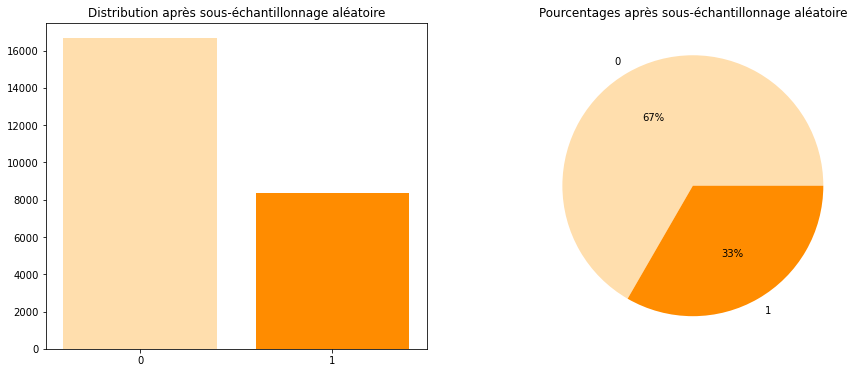

In [5]:
#on a un évenment rare et en plus le nombre d'observations va être un problème pour réaliser des méthodes de Machine Learning
#on va donc réaliser de l'under-sampling
rUs = RandomUnderSampler(sampling_strategy=0.5)
X_ru, y_ru = rUs.fit_resample(base1, Y)


# préparer les données aux graphiques
count=Counter(y_ru).most_common()
graph=[count[0][1], count[1][1]]
colors=['navajowhite', 'darkorange']
labels=["0","1"]

# séparation de la fenêtre
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

# histogramme
ax1.bar(labels, graph,  color=colors)
ax1.set_title('Distribution après sous-échantillonnage aléatoire')

# diagramme
ax2.pie(graph,labels=labels, autopct='%1.f%%', colors=colors)
ax2.set_title('Pourcentages après sous-échantillonnage aléatoire')

plt.show()

### Création d'échantillons 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_ru, y_ru, test_size=0.25, stratify=y_ru, random_state=1)

# 

### SVM

In [7]:
# fixons tout d'abord les hyper-paramètres c et gamma

#nous allons réaliser une CV aléatoire, étant donné le temps nous allons reduire la taille de train, qui est pour
#l'instant de plus de 16000. 

X_train2, X_reste, y_train2, y_reste= train_test_split(X_train, y_train, test_size=0.9)

hyperparameters = {
    "C" : np.arange(0.01,1,0.01),
    "gamma" : np.arange(0.01,1,0.01)
}

SVM = SVC(kernel='rbf')
SVM_hyp = RandomizedSearchCV(SVM, hyperparameters, cv=5, n_iter=20,random_state=4).fit(X_train2,y_train2)


# afficher les paramètres optimaux
print("Les paramètres optimaux sont {} ".format(SVM_hyp.best_params_))

Les paramètres optimaux sont {'gamma': 0.01, 'C': 0.98} 


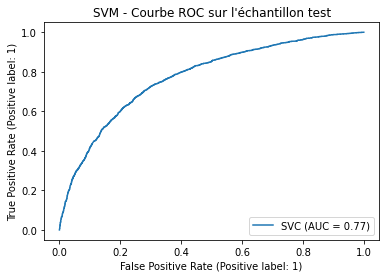

In [8]:
#nous pouvons reprendre les échantillons complets, et les hyperparamètres trouvés.
SVM_f=SVC(kernel='rbf', C =0.98, gamma=0.01, probability=True).fit(X_train, y_train)

plot_roc_curve(SVM_f, X_test, y_test) 
plt.title("SVM - Courbe ROC sur l'échantillon test")
plt.show()

#on garde cette ROC la car elle est basée sur les paires concordantes/ discordantes et liées comme la logistique

In [9]:
y_probs_svm = SVM_f.predict_proba(X_test)[:,1]

fp_rate, tp_rate, thresholds = roc_curve(y_test, y_probs_svm)
gini_svm=2*auc(fp_rate, tp_rate)-1

print("SVM: L'indice de Gini est de: {:.4f}".format(gini_svm))

SVM: L'indice de Gini est de: 0.5471


In [35]:
# à cause du sous-échantillonage il faut trouver la bonne matrice de confusion

#on trouve pi_0 et pi_1 les vraies probabilités de défaut
count_vrai=Counter(Y).most_common()
sum_vrai=count_vrai[0][1]+ count_vrai[1][1]
pi_0=count_vrai[0][1]/sum_vrai
pi_1=1-pi_0

In [49]:
# on doit fixer le cut-off
I_cutoff = np.arange(0.1,1,0.1)
for cutoff in I_cutoff:
    print("cutoff: " + str(cutoff))
    y_pred_svm=(y_probs_svm>cutoff)
    cm = confusion_matrix(y_test, y_pred_svm, normalize='true') 
    #ajustement lié au sous-échantillonage
    cm[0]=cm[0]*pi_0 
    cm[1]=cm[1]*pi_1
    #pour avoir des pourcentages par ligne
    cm[0][0]=cm[0][0]/(cm[0][0]+cm[0][1])
    cm[0][1]=1-cm[0][0]
    cm[1][0]=cm[1][0]/(cm[1][0]+cm[1][1])
    cm[1][1]=1-cm[1][0]
    print (cm)

cutoff: 0.1
[[0.0237581  0.9762419 ]
 [0.00239923 0.99760077]]
cutoff: 0.2
[[0.51979842 0.48020158]
 [0.15642994 0.84357006]]
cutoff: 0.30000000000000004
[[0.7612191  0.2387809 ]
 [0.35172745 0.64827255]]
cutoff: 0.4
[[0.8387329  0.1612671 ]
 [0.46161228 0.53838772]]
cutoff: 0.5
[[0.89224862 0.10775138]
 [0.56333973 0.43666027]]
cutoff: 0.6
[[0.92632589 0.07367411]
 [0.6621881  0.3378119 ]]
cutoff: 0.7000000000000001
[[0.96016319 0.03983681]
 [0.75767754 0.24232246]]
cutoff: 0.8
[[0.98344132 0.01655868]
 [0.88291747 0.11708253]]
cutoff: 0.9
[[0.99856012 0.00143988]
 [0.98176583 0.01823417]]


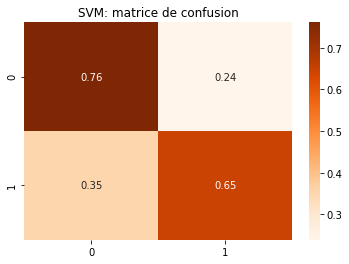

In [51]:
# on veut minimiser l'erreur 
# on fixe donc le cutoff à 0.3
y_pred_svm=(y_probs_svm>0.3)

#la matrice de confusion avant transformation
cm = confusion_matrix(y_test, y_pred_svm, normalize='true')

#ajustement lié au sous-échantillonage
cm[0]=cm[0]*pi_0 
cm[1]=cm[1]*pi_1

#pour avoir des pourcentages par ligne
cm[0][0]=cm[0][0]/(cm[0][0]+cm[0][1])
cm[0][1]=1-cm[0][0]
cm[1][0]=cm[1][0]/(cm[1][0]+cm[1][1])
cm[1][1]=1-cm[1][0]

f = sns.heatmap(cm, annot=True, cmap=plt.cm.Oranges)
plt.title("SVM: matrice de confusion")
plt.show()

#  

### RandomForest 

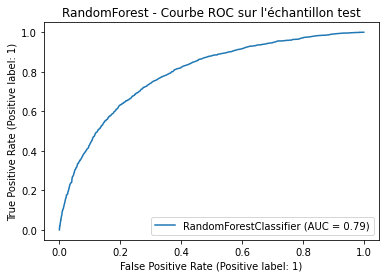

In [38]:
Rf = RandomForestClassifier(criterion="gini", n_estimators=1000, max_features="sqrt").fit(X_train, y_train)

plot_roc_curve(Rf, X_test, y_test) 
plt.title("RandomForest - Courbe ROC sur l'échantillon test")
plt.show()

#on garde cette ROC la car elle est basée sur les paires concordantes/ discordantes et liées comme la logistique

In [39]:
y_probs_Rf = Rf.predict_proba(X_test)[:,1]

fp_rate, tp_rate, thresholds = roc_curve(y_test, y_probs_Rf)
gini_Rf=2*auc(fp_rate, tp_rate)-1

print("RandomForest: L'indice de Gini est de: {:.4f}".format(gini_Rf))

RandomForest: L'indice de Gini est de: 0.5818


In [52]:
# on a les vraies probabilités
# on doit fixer le cut-off
I_cutoff = np.arange(0.1,1,0.1)
for cutoff in I_cutoff:
    print("cutoff: " + str(cutoff))
    y_pred_Rf=(y_probs_Rf>cutoff)
    cm = confusion_matrix(y_test, y_pred_Rf, normalize='true') 
    #ajustement lié au sous-échantillonage
    cm[0]=cm[0]*pi_0 
    cm[1]=cm[1]*pi_1
    #pour avoir des pourcentages par ligne
    cm[0][0]=cm[0][0]/(cm[0][0]+cm[0][1])
    cm[0][1]=1-cm[0][0]
    cm[1][0]=cm[1][0]/(cm[1][0]+cm[1][1])
    cm[1][1]=1-cm[1][0]
    print (cm)

cutoff: 0.1
[[0.19030478 0.80969522]
 [0.02543186 0.97456814]]
cutoff: 0.2
[[0.4550036  0.5449964 ]
 [0.10460653 0.89539347]]
cutoff: 0.30000000000000004
[[0.65586753 0.34413247]
 [0.22072937 0.77927063]]
cutoff: 0.4
[[0.79313655 0.20686345]
 [0.35988484 0.64011516]]
cutoff: 0.5
[[0.88360931 0.11639069]
 [0.5206334  0.4793666 ]]
cutoff: 0.6
[[0.94384449 0.05615551]
 [0.6828215  0.3171785 ]]
cutoff: 0.7000000000000001
[[0.98152148 0.01847852]
 [0.85268714 0.14731286]]
cutoff: 0.8
[[0.99640029 0.00359971]
 [0.95825336 0.04174664]]
cutoff: 0.9
[[1.         0.        ]
 [0.99424184 0.00575816]]


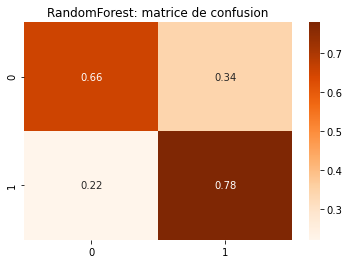

In [53]:
# on veut minimiser l'erreur donc on fixe donc le cutoff à 0.3
y_pred_Rf=(y_probs_Rf>0.3)

#la matrice de confusion avant transformation
cm = confusion_matrix(y_test, y_pred_Rf, normalize='true')

#ajustement lié au sous-échantillonage
cm[0]=cm[0]*pi_0 
cm[1]=cm[1]*pi_1

#pour avoir des pourcentages par ligne
cm[0][0]=cm[0][0]/(cm[0][0]+cm[0][1])
cm[0][1]=1-cm[0][0]
cm[1][0]=cm[1][0]/(cm[1][0]+cm[1][1])
cm[1][1]=1-cm[1][0]

f = sns.heatmap(cm, annot=True, cmap=plt.cm.Oranges)
plt.title("RandomForest: matrice de confusion")
plt.show()